## Import Modules

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from tensorflow.keras import layers, initializers, metrics, losses, Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import array_to_img, load_img, img_to_array
from tensorflow.keras.callbacks import Callback

warnings.filterwarnings('ignore')

In [3]:
def visualize_images(temp_images):
    plt.figure(figsize=(20, 20))
    index = 1
    for image_path in temp_images:
        plt.subplot(7, 7, index)
        img = load_img(image_path)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
        index += 1

In [3]:
def resize_images(image_paths, new_size):
    resized_images = []
    for path in image_paths:
        img = load_img(path, target_size=new_size)
        img = img_to_array(img) #python image library to numpy array
        resized_images.append(img)
    return np.array(resized_images)

In [4]:
def build_generator(LATENT_DIM, CHANNELS, WEIGHT_INIT):
    model = Sequential(name='generator')
    model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))  #512 = feature maps
    model.add(layers.ReLU())
    model.add(layers.Reshape((8, 8, 512)))
    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT)) #filter=256
    model.add(layers.ReLU())
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
    model.add(layers.ReLU())
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
    model.add(layers.ReLU())
    model.add(layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
    model.add(layers.ReLU())
    model.add(layers.Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh'))
    return model

In [5]:
def build_discriminator(input_shape, alpha):
    model = Sequential(name='discriminator')
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha)) 
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3)) #prevent overfitting.
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [6]:
class DCGAN(Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim #The dimensionality of the latent space, which is the input to the generator.
        self.g_loss_metric = metrics.Mean(name='g_loss')
        self.d_loss_metric = metrics.Mean(name='d_loss')

    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]

    def compile(self, g_optimizer, d_optimizer, loss_fn): #optimizer - updating the weights of the generator during training.
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        # get batch size from the data
        batch_size = tf.shape(real_images)[0]
        # generate random noise
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        # train the discriminator with real (1) and fake (0) images
        with tf.GradientTape() as tape:
            # compute loss on real images
            pred_real = self.discriminator(real_images, training=True)
            # generate real image labels
            real_labels = tf.ones((batch_size, 1)) #1 for real images
            # label smoothing
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels)) #overconfident na ho
            d_loss_real = self.loss_fn(real_labels, pred_real)
            # compute loss on fake images
            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            # generate fake labels
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)
            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2
        # compute discriminator gradients
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # update the gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))
        # train the generator model
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # generate fake images from generator
            fake_images = self.generator(random_noise, training=True)
            # classify images as real or fake
            pred_fake = self.discriminator(fake_images, training=True)
            # compute loss
            g_loss = self.loss_fn(tf.ones((batch_size, 1)), pred_fake)
        # compute gradients
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        # update the gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))
        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

In [7]:
class DCGANMonitor(Callback):
    def __init__(self, num_imgs=25, latent_dim=100):
        super().__init__()
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 == 0:  # Plots image after 20 epochs
            # generate the image from noise
            g_img_ = self.model.generator(self.noise)
            # denormalize the image
            g_img = (g_img_ * 127.5) + 127.5 #range [-1, 1] to the range [0, 255].
            g_img = g_img.numpy()  # to convert Tensor to numpy array

            plt.figure(figsize=(8, 8))
            for i in range(self.num_imgs):
                plt.subplot(5, 5, i + 1)
                img = array_to_img(g_img[i])
                plt.imshow(img)
                plt.axis('off')
            plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

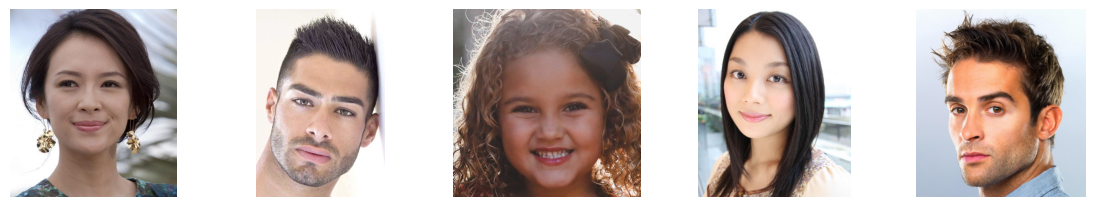

In [8]:
BASE_DIR = 'Humans/'

# Load complete image paths to the list
image_paths = [os.path.join(BASE_DIR, image_name) for image_name in os.listdir(BASE_DIR)]

# Visualize first 5 images
visualize_images(image_paths[:50])

In [9]:
# Preprocess images
new_size = (128, 128)
train_images = resize_images(image_paths, new_size)

# Reshape and normalize the images
train_images = train_images.reshape(train_images.shape[0], 128, 128, 3).astype('float32') #3-channel (rgb)
train_images = (train_images - 127.5) / 127.5  #pixel values of the images to be in the range [-1, 1]

In [10]:
# Define generator and discriminator models
LATENT_DIM = 100
CHANNELS = 3
WEIGHT_INIT = initializers.RandomNormal(mean=0.0, stddev=0.02)
generator = build_generator(LATENT_DIM, CHANNELS, WEIGHT_INIT)
discriminator = build_discriminator(input_shape=(128, 128, 3), alpha=0.2)

#the latent space is a vector space from which random samples (latent vectors) are drawn to generate new data.

In [11]:
# Build DCGAN model 
dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim=LATENT_DIM)

In [12]:
# Compile DCGAN
dcgan.compile(g_optimizer=Adam(learning_rate=0.0003, beta_1=0.5),
              d_optimizer=Adam(learning_rate=0.0001, beta_1=0.5),
              loss_fn=losses.BinaryCrossentropy())

#BinaryCrossentropy() - where the goal is to train the discriminator to distinguish between real and fake samples.

Epoch 1/100
226/226 [==============================] - ETA: 0s - d_loss: 2.0936 - g_loss: 1.5568

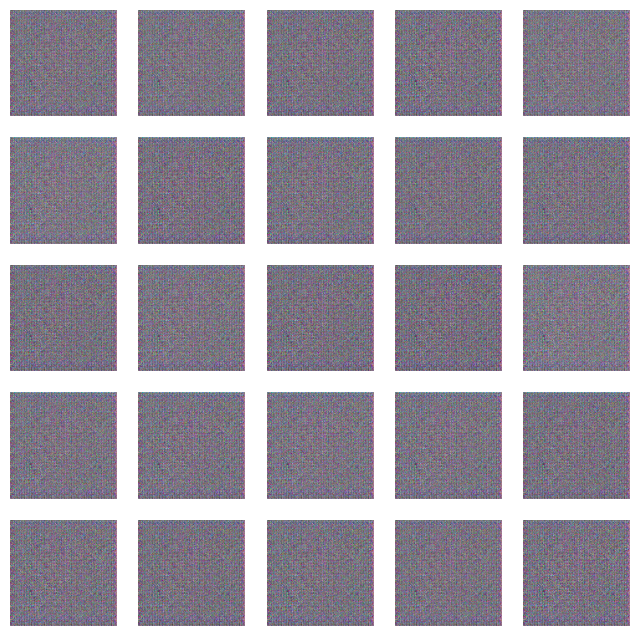

226/226 [==============================] - 257s 1s/step - d_loss: 2.0936 - g_loss: 1.5568
Epoch 2/100
226/226 [==============================] - 248s 1s/step - d_loss: 0.0071 - g_loss: 5.4205
Epoch 3/100
226/226 [==============================] - 254s 1s/step - d_loss: -0.4006 - g_loss: 5.8078
Epoch 4/100
226/226 [==============================] - 329s 1s/step - d_loss: 0.2227 - g_loss: 14.2419
Epoch 5/100
226/226 [==============================] - 262s 1s/step - d_loss: 0.5219 - g_loss: 6.7442
Epoch 6/100
226/226 [==============================] - 280s 1s/step - d_loss: 0.7227 - g_loss: 3.3360
Epoch 7/100
226/226 [==============================] - 292s 1s/step - d_loss: 0.6333 - g_loss: 3.5175
Epoch 8/100
226/226 [==============================] - 272s 1s/step - d_loss: 0.5986 - g_loss: 3.1293
Epoch 9/100
226/226 [==============================] - 443s 2s/step - d_loss: 0.6207 - g_loss: 2.0927
Epoch 10/100
226/226 [==============================] - 253s 1s/step - d_loss: 0.5708 - g_lo

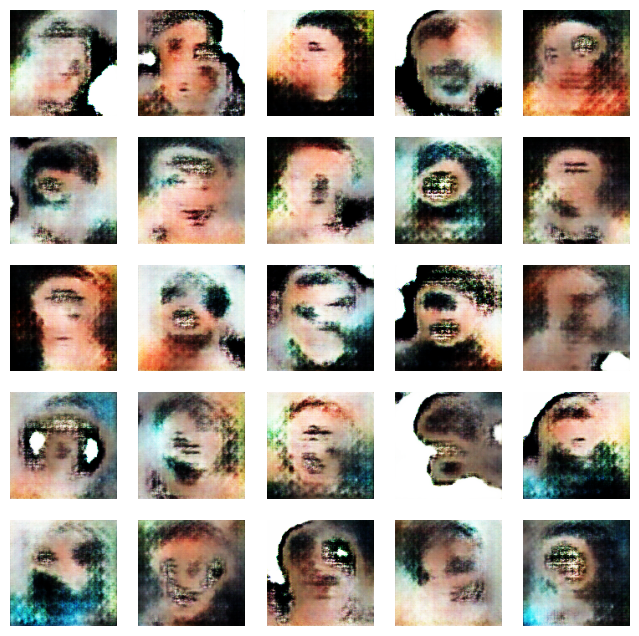

226/226 [==============================] - 238s 1s/step - d_loss: 0.7758 - g_loss: 1.6792
Epoch 22/100
226/226 [==============================] - 240s 1s/step - d_loss: 0.7688 - g_loss: 1.6554
Epoch 23/100
226/226 [==============================] - 246s 1s/step - d_loss: 0.7709 - g_loss: 1.7454
Epoch 24/100
226/226 [==============================] - 237s 1s/step - d_loss: 0.8017 - g_loss: 1.6622
Epoch 25/100
226/226 [==============================] - 237s 1s/step - d_loss: 0.8446 - g_loss: 1.6680
Epoch 26/100
226/226 [==============================] - 237s 1s/step - d_loss: 0.8585 - g_loss: 1.7989
Epoch 27/100
226/226 [==============================] - 239s 1s/step - d_loss: 0.8581 - g_loss: 1.5981
Epoch 28/100
226/226 [==============================] - 260s 1s/step - d_loss: 0.8797 - g_loss: 1.5727
Epoch 29/100
226/226 [==============================] - 257s 1s/step - d_loss: 0.8795 - g_loss: 1.4856
Epoch 30/100
226/226 [==============================] - 268s 1s/step - d_loss: 0.8932 

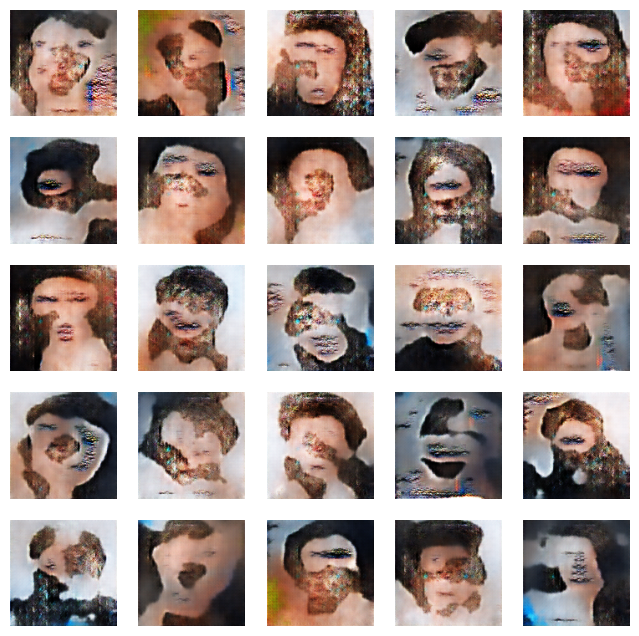

226/226 [==============================] - 255s 1s/step - d_loss: 0.8443 - g_loss: 1.3704
Epoch 42/100
226/226 [==============================] - 255s 1s/step - d_loss: 0.8421 - g_loss: 1.3706
Epoch 43/100
226/226 [==============================] - 260s 1s/step - d_loss: 0.8336 - g_loss: 1.3701
Epoch 44/100
226/226 [==============================] - 258s 1s/step - d_loss: 0.8417 - g_loss: 1.3484
Epoch 45/100
226/226 [==============================] - 246s 1s/step - d_loss: 0.8388 - g_loss: 1.3301
Epoch 46/100
226/226 [==============================] - 254s 1s/step - d_loss: 0.8278 - g_loss: 1.3418
Epoch 47/100
226/226 [==============================] - 245s 1s/step - d_loss: 0.8126 - g_loss: 1.4037
Epoch 48/100
226/226 [==============================] - 244s 1s/step - d_loss: 0.7968 - g_loss: 1.3710
Epoch 49/100
226/226 [==============================] - 273s 1s/step - d_loss: 0.8201 - g_loss: 1.3948
Epoch 50/100
226/226 [==============================] - 248s 1s/step - d_loss: 0.8094 

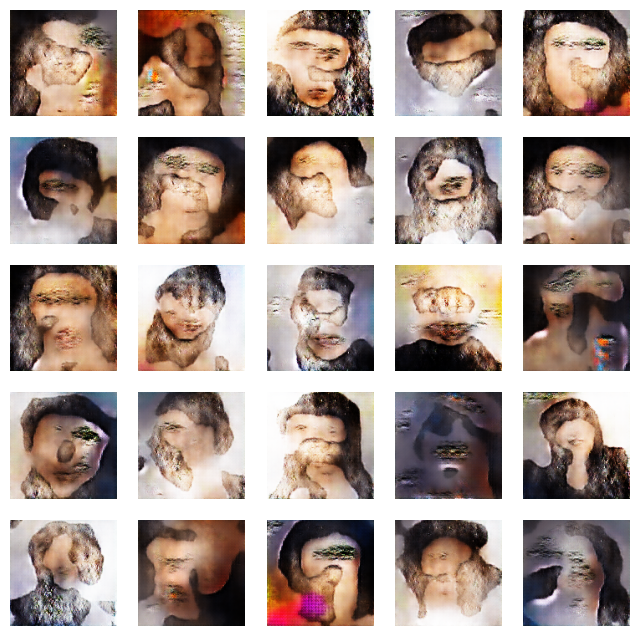

226/226 [==============================] - 266s 1s/step - d_loss: 0.7534 - g_loss: 1.4243
Epoch 62/100
226/226 [==============================] - 255s 1s/step - d_loss: 0.7370 - g_loss: 1.4169
Epoch 63/100
226/226 [==============================] - 290s 1s/step - d_loss: 0.7488 - g_loss: 1.4654
Epoch 64/100
226/226 [==============================] - 269s 1s/step - d_loss: 0.7313 - g_loss: 1.4737
Epoch 65/100
226/226 [==============================] - 249s 1s/step - d_loss: 0.7307 - g_loss: 1.4539
Epoch 66/100
226/226 [==============================] - 265s 1s/step - d_loss: 0.7132 - g_loss: 1.4966
Epoch 67/100
226/226 [==============================] - 262s 1s/step - d_loss: 0.7267 - g_loss: 1.5422
Epoch 68/100
226/226 [==============================] - 344s 2s/step - d_loss: 0.7156 - g_loss: 1.5026
Epoch 69/100
226/226 [==============================] - 271s 1s/step - d_loss: 0.7096 - g_loss: 1.5074
Epoch 70/100
226/226 [==============================] - 261s 1s/step - d_loss: 0.6990 

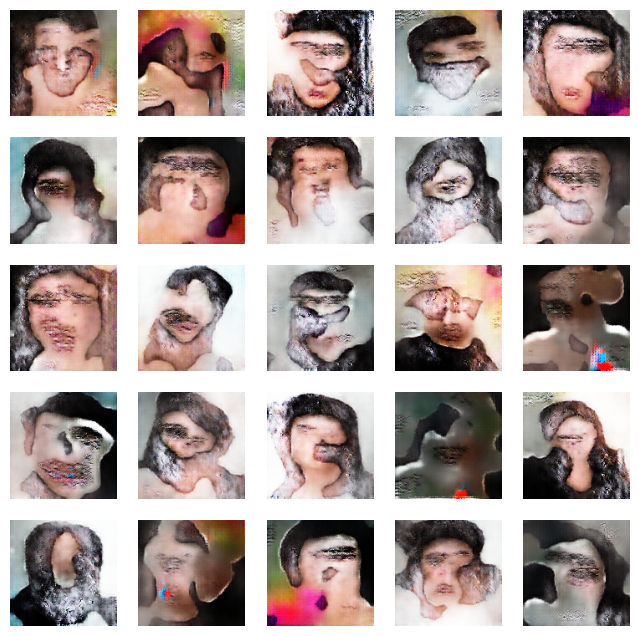

226/226 [==============================] - 266s 1s/step - d_loss: 0.6424 - g_loss: 1.6382
Epoch 82/100
226/226 [==============================] - 243s 1s/step - d_loss: 0.6598 - g_loss: 1.6240
Epoch 83/100
226/226 [==============================] - 243s 1s/step - d_loss: 0.6488 - g_loss: 1.6184
Epoch 84/100
226/226 [==============================] - 246s 1s/step - d_loss: 0.6615 - g_loss: 1.6433
Epoch 85/100
226/226 [==============================] - 240s 1s/step - d_loss: 0.6502 - g_loss: 1.6440
Epoch 86/100
226/226 [==============================] - 239s 1s/step - d_loss: 0.6434 - g_loss: 1.6424
Epoch 87/100
226/226 [==============================] - 240s 1s/step - d_loss: 0.6588 - g_loss: 1.6846
Epoch 88/100
226/226 [==============================] - 239s 1s/step - d_loss: 0.6229 - g_loss: 1.6846
Epoch 89/100
226/226 [==============================] - 239s 1s/step - d_loss: 0.6146 - g_loss: 1.6713
Epoch 90/100
226/226 [==============================] - 240s 1s/step - d_loss: 0.6463 

In [13]:
# Train the Model
history = dcgan.fit(train_images, epochs=1000, callbacks=[DCGANMonitor()])

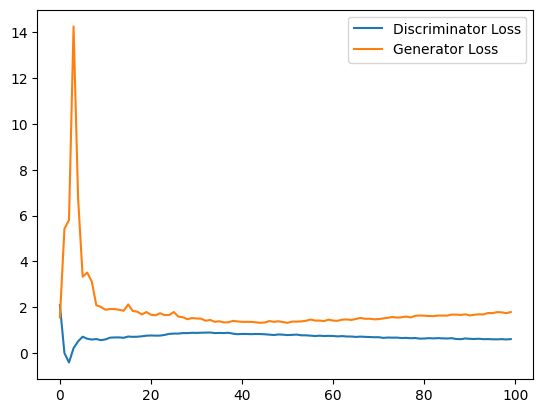

In [15]:
plt.plot(history.history['d_loss'], label='Discriminator Loss')
plt.plot(history.history['g_loss'], label='Generator Loss')
plt.legend()
plt.show()

## Generate New Faces

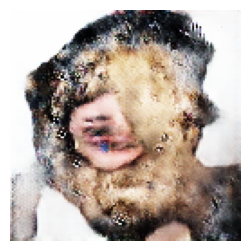

In [22]:
noise = tf.random.normal([1, 100])
fig = plt.figure(figsize=(3, 3))
# generate the image from noise
g_img = dcgan.generator(noise)
# denormalize the image
g_img = (g_img * 127.5) + 127.5
g_img.numpy()
img = array_to_img(g_img[0])
plt.imshow(img)
plt.axis('off')
plt.show()

In [21]:
# Save the model
dcgan.generator.save('generator1.h5')

In [18]:
# Load the model
generator = tf.keras.models.load_model('generator1.h5')

In [19]:
# Compile the model
generator.compile()

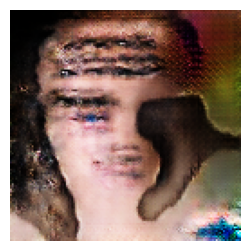

In [26]:
# generate new image
noise = tf.random.normal([1, 100])
fig = plt.figure(figsize=(3, 3))
# generate the image from noise
g_img = generator(noise)
# denormalize the image
g_img = (g_img * 127.5) + 127.5
g_img.numpy()
img = array_to_img(g_img[0])
plt.imshow(img)
plt.axis('off')
plt.show()

ValueError: num must be an integer with 1 <= num <= 49, not 50

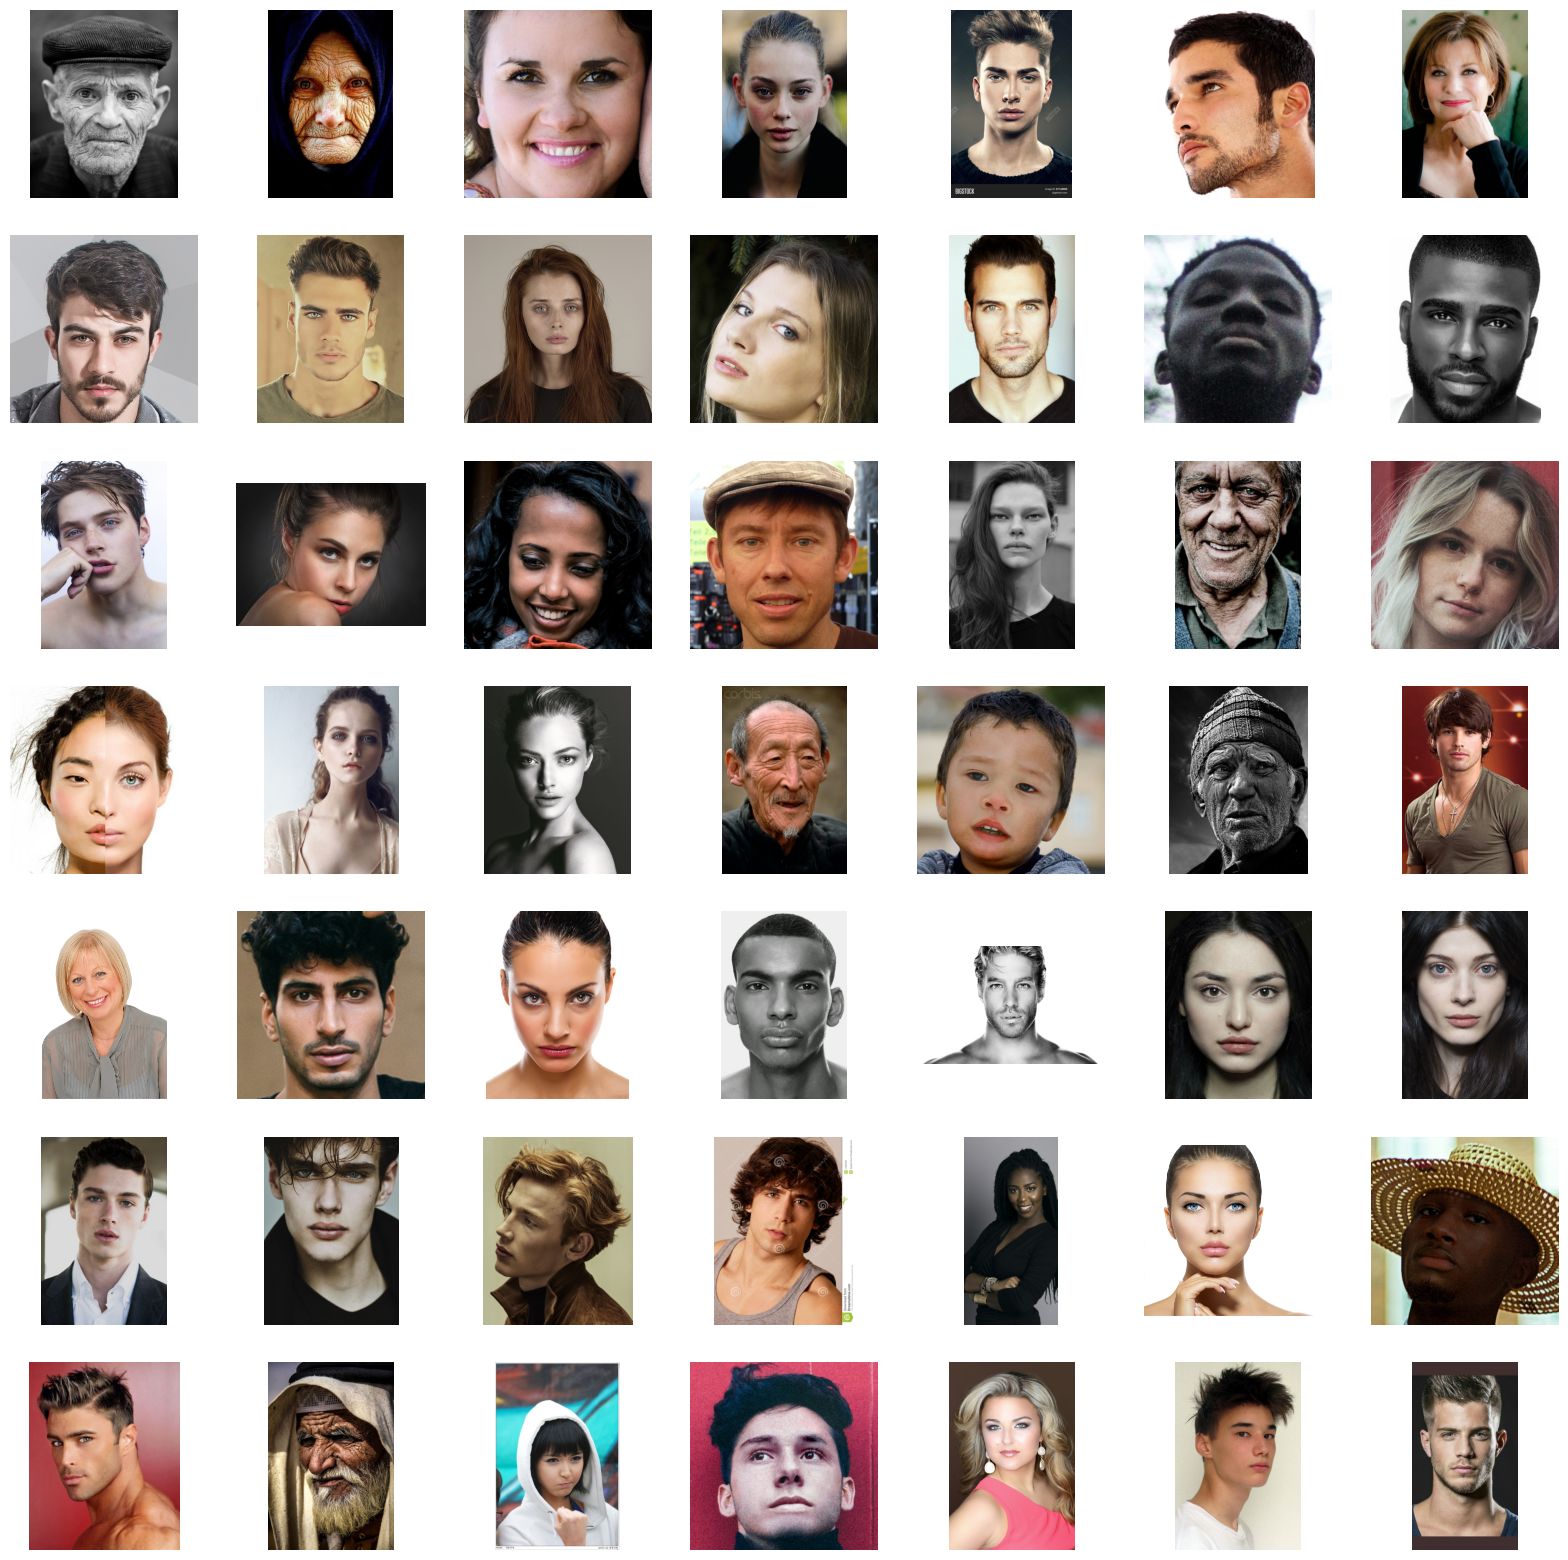

In [7]:
BASE_DIR = 'Humans/'

# Load complete image paths to the list
image_paths = [os.path.join(BASE_DIR, image_name) for image_name in os.listdir(BASE_DIR)]

# Visualize first 5 images
visualize_images(image_paths[100:300])